<a href="https://colab.research.google.com/github/vineetsalar88/ResrachPaper2/blob/master/17Dec25Obj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [4]:
# 1️⃣ Load CSV
# -------------------------------
csv_path = "/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotations.csv"
image_folder = "/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images"   # folder containing your image files

df = pd.read_csv(csv_path)

# Add full image paths
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_folder, x))
pd.set_option('display.max_colwidth', None)
print(df['image_path'].head(10))





0    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/001.jpg
1    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/002.jpg
2    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/003.jpg
3    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/004.jpg
4    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/004.jpg
5    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/005.jpg
6    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/006.jpg
7    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/007.jpg
8    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/008.jpg
9    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/008.jpg
Name: image_path, dtype: object


In [5]:
from PIL import Image
import os

broken_images = []

for path in df['image_path']:
    try:
        img = Image.open(path)
        img.verify()  # verify doesn't load the whole image, just checks integrity
    except Exception as e:
        broken_images.append((path, str(e)))

print(f"Found {len(broken_images)} broken images.")
for b in broken_images[:10]:
    print(b)


Found 0 broken images.


In [7]:
df.dropna(subset=['label'], inplace=True)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [8]:
#Create ImageDataGenerators -------------------------------
img_size = (128, 128)
batch_size = 32

# Filter out rows with invalid image paths
train_df = train_df[train_df['image_path'].apply(lambda x: os.path.exists(x))]
val_df = val_df[val_df['image_path'].apply(lambda x: os.path.exists(x))]

# Add a robust check for image loading and resizing issues
def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize(img_size) # Try resizing to trigger potential errors
        img.verify()
        return True
    except Exception as e:
        print(f"Could not load or process image {image_path}: {e}")
        return False

# Filter dataframes based on image loadability
train_df_cleaned = train_df[train_df['image_path'].apply(is_image_loadable)]
val_df_cleaned = val_df[val_df['image_path'].apply(is_image_loadable)]

print(f"Original train_df size: {len(train_df)}, Cleaned train_df size: {len(train_df_cleaned)}")
print(f"Original val_df size: {len(val_df)}, Cleaned val_df size: {len(val_df_cleaned)}")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df_cleaned,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df_cleaned,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Original train_df size: 552, Cleaned train_df size: 552
Original val_df size: 138, Cleaned val_df size: 138
Found 552 validated image filenames belonging to 8 classes.
Found 138 validated image filenames belonging to 8 classes.


In [15]:
# Make sure to run the cell above this one (cell `0zqEiKczWeK6`) to define `img_size`, `train_gen`, and `val_gen` first.
# 4️⃣ Build CNN Model
# -------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2022 - loss: 2.0058

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.2048 - loss: 2.0010 - val_accuracy: 0.2681 - val_loss: 1.7901
Epoch 2/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.2708 - loss: 1.7983 - val_accuracy: 0.3043 - val_loss: 1.7089
Epoch 3/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.3357 - loss: 1.7392 - val_accuracy: 0.3116 - val_loss: 1.7116
Epoch 4/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.2621 - loss: 1.7735 - val_accuracy: 0.2681 - val_loss: 1.7764
Epoch 5/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.3103 - loss: 1.7581 - val_accuracy: 0.3478 - val_loss: 1.6350
Epoch 6/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.2915 - loss: 1.7017 - val_accuracy: 0.3478 - val_loss: 1.6221
Epoch 7/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.3459 - loss: 1.6698 - val_accuracy: 0.3261 - val_loss: 1.7787
Epoch 8/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.2779 - loss: 1.6913 - val_accuracy: 0.3261 - val_loss: 1.6552
Epo

✅ Validation Accuracy: 34.78%


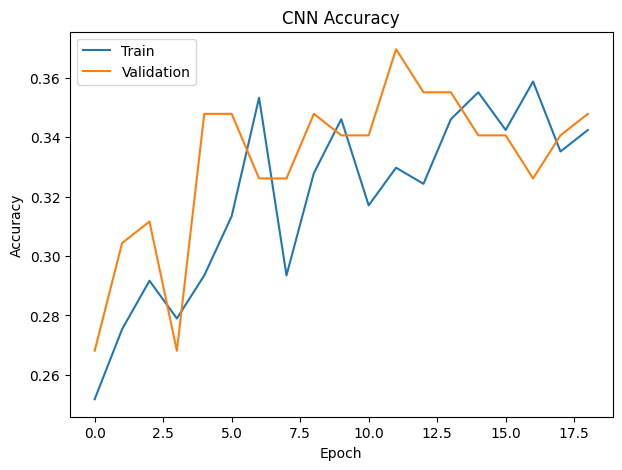

In [16]:
# Make sure to run the cell above this one to define and compile the model first.
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=19
)

# ============================================
# ❓ 9⏹  Evaluate and Save
# ============================================
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")

model.save("cnn_multiclass_bbox_model.h5")

# ============================================
# ❓ ⟹⏹  Optional: Plot Accuracy
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()